# Predykcja płci po imieniu

### Celem jest zrobić bardziej zaawansowany model, niż poprzednio

Tym razem zastosujmy drzewa decyzyjne. Czemu akurat drzewa? Jest to logiczny krok do przodu. Więcej o drzewach decyzyjnych i innych "drzewiastych" algorytmach będzie w kolejnych modułach.

In [1]:
import pandas as pd
import numpy as np

#ustwiamy ziarnko (seed), dla powtarzalności w losowaniu
np.random.seed(2018) # <== może być dowolna liczba, ale trzeba wybrać coś... więc rok 2018 :)

#models (algorithms)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#walidacja wyniku
from sklearn.model_selection import train_test_split

#metryka sukcesu
from sklearn.metrics import accuracy_score # <== our success metric

#wizualizacja
import matplotlib.pyplot as plt

# <== umożliwia robić wykresy w notebook'u, zamiast otwierać w oknie
%matplotlib inline 

In [2]:
df = pd.read_csv("../input/polish_names.csv")

In [4]:
df['target'] = df['gender'].map(lambda x: int(x == 'm'))
df

,name,gender,target
0,Abdon,m,1
1,Abel,m,1
2,Abercjusz,m,1
3,Abraham,m,1
4,Absalon,m,1
5,Achacjusz,m,1
6,Achacy,m,1
7,Achilles,m,1
8,Ada,f,0
9,Adalbert,m,1


In [5]:
def train_and_predict_model(X_train, X_test, y_train, y_test, model, success_metric=accuracy_score):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return success_metric(y_test, y_pred)

## Feature engineering 

Tworzymy nowe cechy na podstawie już istniejących. 

Ten proces jest bardzo ważny i dlatego powstał nawet osobny moduł tylko na temat "**feature engineering**". Cała trudność w tym procesie polega na tym, że to jest bardziej sztuka, a mniej nauka. 

Trzeba nauczyć się "wyczuwać" co należy zrobić i też odpowiednio zacząć myśleć. Postaraj się myśleć w taki sposób, jaka informacja może być pomocna dla modelu, żeby podjąć prawidłową decyzję.

In [6]:
vowels = ['a', 'ą', 'e', 'ę', 'i', 'o', 'u', 'y']

def how_many_vowels(name):
    return sum( map(lambda x: int(x in vowels), name.lower()) )
    
def first_is_vowel(name):
    return name.lower()[0] in vowels

def last_is_vowel(name):
    return name.lower()[-1] in vowels

def get_all_vowels(name):
    all_vowels = [letter for letter in name.lower() if letter in vowels]
    
    return ''.join(all_vowels)

def get_all_consonants(name):
    all_consonants = [letter for letter in name.lower() if letter not in vowels]
    
    return ''.join(all_consonants)

def feature_engineering(df):
    df['len_name'] = df['name'].map(lambda x: len(x))
    
    df['first_is_vowel'] = df['name'].map(first_is_vowel)
    df['last_is_vowel'] = df['name'].map(last_is_vowel)
    
    df['first_letter'] = df['name'].map(lambda x: x.lower()[0])
    df['first_letter_cnt'] = pd.factorize(df['first_letter'])[0]
    
    df['last_letter'] = df['name'].map(lambda x: x.lower()[-1])
    df['last_letter_cnt'] = pd.factorize(df['last_letter'])[0]
    
    df['all_vowels'] = df['name'].map(get_all_vowels)
    df['all_vowels_cnt'] = pd.factorize(df['all_vowels'])[0]

    df['all_consonants'] = df['name'].map(get_all_consonants)
    df['all_consonants_cnt'] = pd.factorize(df['all_consonants'])[0]
    
    
    return df  

In [8]:
df_fe = feature_engineering(df)
df_fe

,name,gender,target,len_name,first_is_vowel,last_is_vowel,first_letter,first_letter_cnt,last_letter,last_letter_cnt,all_vowels,all_vowels_cnt,all_consonants,all_consonants_cnt
0,Abdon,m,1,5,True,False,a,0,n,0,ao,0,bdn,0
1,Abel,m,1,4,True,False,a,0,l,1,ae,1,bl,1
2,Abercjusz,m,1,9,True,False,a,0,z,2,aeu,2,brcjsz,2
3,Abraham,m,1,7,True,False,a,0,m,3,aaa,3,brhm,3
4,Absalon,m,1,7,True,False,a,0,n,0,aao,4,bsln,4
5,Achacjusz,m,1,9,True,False,a,0,z,2,aau,5,chcjsz,5
6,Achacy,m,1,6,True,True,a,0,y,4,aay,6,chc,6
7,Achilles,m,1,8,True,False,a,0,s,5,aie,7,chlls,7
8,Ada,f,0,3,True,True,a,0,a,6,aa,8,d,8
9,Adalbert,m,1,8,True,False,a,0,t,7,aae,9,dlbrt,9


In [9]:
features = ['len_name', 'first_is_vowel', 'last_is_vowel', 'first_letter_cnt', 'last_letter_cnt', 'all_vowels_cnt', 'all_consonants_cnt']
X = df_fe[ features ]
y = df_fe['target']

train_and_predict_model(X, X, y, y, LogisticRegression())

0.9524926686217009

## Train & Test

Teraz podzielmy nasz zbiór danych na **treningowy** i **testowy**. Robimy to po to, żeby uniknąć przeuczenia się. Co to jest i dlaczego to jest złe będzie poruszone w następnych modułach. Na razie weźmiemy coś najprostszego. Podzielimy zbiór danych na dwie cześci: 70% na zbiór treningowy i 30% na zbiór testowy. 

Trenujemy dane tylko na zbiorze treningowym i sprawdzamy jakość na zbiorze testowym. Właściwie sprawdzamy na obu i co ważne, jeśli jakość na zbiorze treningowym jest bardzo dobra (np. 90%), a na zbiorze testowym bardzo zła (np. 60%) to już powinna zapalić się czerwona lampka - model przeuczył się (ang. *overfitting*).

#### Czemu podział jest **70% vs 30%**? 
Jakiś musi być. Może być np. `80% vs 20%` lub `60% vs 40%`. Domyślnie bierze się 30% na zbiór testowy. 

#### Dlaczego na zbiór testowy bierze się mniej? 
Dlatego, że zwykle danych jest mało lub bardzo mało i zbiór testowy to w pewnym sensie "marnowanie" danych, bo na nich tylko sprawdzamy (nie uczymy modelu). Dlatego chcemy "odłożyć" na testowanie jak najmniej, ale tyle, żeby to miało sens.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
y_train
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (1193, 7) (1193,)
Test: (512, 7) (512,)


,len_name,first_is_vowel,last_is_vowel,first_letter_cnt,last_letter_cnt,all_vowels_cnt,all_consonants_cnt
1550,8,False,False,23,7,138,1177
186,6,False,True,1,6,83,149
737,9,False,True,9,6,192,577
1159,5,False,False,16,18,8,889
1667,7,False,False,12,2,280,1266
1600,7,False,False,25,21,72,1220
288,10,False,False,2,18,144,232
7,8,True,False,0,5,7,7
530,7,False,False,6,1,7,413
1285,6,False,False,17,0,65,979


In [18]:
train_and_predict_model(X_train, X_test, y_train, y_test, LogisticRegression())

0.962890625

## Krzywy uczenia się (ang. [`learning curves`](https://www.youtube.com/watch?v=ISBGFY-gBug))


**Uwaga!** Teraz będzie sporo kodu, ale na początek w ogóle nie musisz go analizować (zwłaszcza jeśli dopiero zaczynasz przygodę z Python). Najważniejsze jest coś innego. Zrozumieć jak interpretować wykres, ale nawet interpretacja na początku może być dość uproszczona.

Krzywa uczenia się, to narzędzie, które pomaga wykrywać czy nastąpiło przeuczenie się (ang. *[overfitting](https://en.wikipedia.org/wiki/Overfitting)*). 

#### Dlaczego to jest ważne? 
O tym będzie mowa szczegółowo w kolejnych modułach. Natomiast zapamiętaj teraz, że zadaniem modelu jest uogólnienie wiedzy. W praktyce to oznacza, że model musi wyciągnąć z danych historycznych pewne wzorce (czasem mówi się "prawo natury"), które mogą wystąpić w przyszłości, ale zignorować szczególne przypadki, które wystąpiły w przeszłości (tak zwany szum).

In [19]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

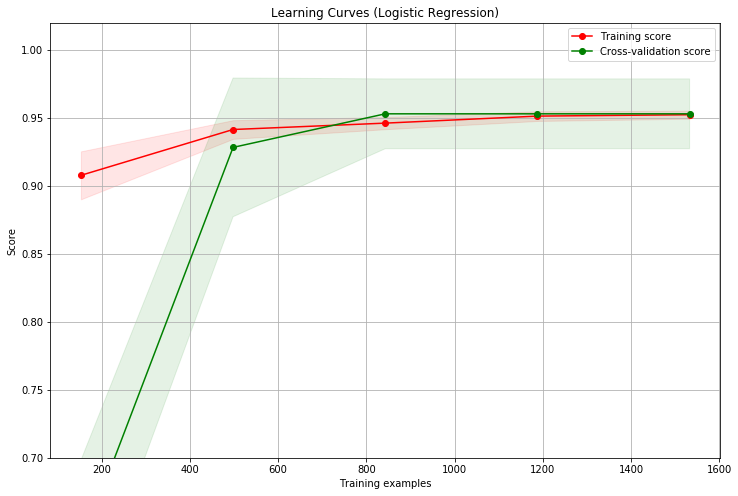

In [20]:
plt = plot_learning_curve(LogisticRegression(), "Learning Curves (Logistic Regression)", X, y, ylim=(0.7, 1.02), cv=10, n_jobs=4)
plt.show()

Na osi X jest rozmiar zbioru treningowego. Na osi Y jakość modelu, w tym przypadku dokładność (ang. [*accuracy*](https://en.wikipedia.org/wiki/Accuracy_and_precision)).

**Zwróć uwagę**, czerwona linia pokazuje wynik dla zbioru treningowego (zwykle jest lepszy, bo na tym zbiorze uczymy się). Nam zależy na tym, żeby na zbiorze testowym, również wynik był dobry (zielona linia). Warto obserwować co się dzieje, z liniami kiedy zwiększamy zbiór treningowy - czy one zbiegają (przecinają) się czy jest odwrotnie?

**Pamiętaj**, wizualizacja procesu trenowania modelu zwykle dostarcza ciekawych wniosków. Jakiś czas temu, **[Peter Norvig](https://en.wikipedia.org/wiki/Peter_Norvig)** (Director of Research w Google) powiedział, że Google ma te same algorytmy, ale jest lepszy (w sensie Google jest lepszy od innych), bo ma więcej danych. 

Często się tak dzieje, że ilość danych ma wpływ na jakość modelu, zwłaszcza kiedy mówimy o Deep Learning, widzimy wtedy, że im więcej danych, tym model staje się coraz lepszy.

W naszym przypadku akurat widać, że mając już 800 imion, jest to całkiem wystarczające, a dalej już dokładność jest podobna. Tutaj, warto zacytować ludzi z [Netflix](https://www.slideshare.net/InfoQ/machine-learning-recommender-systems-at-netflix-scale) którzy powiedzieli to samo (tylko na znacznie większą skalę): nie zawsze więcej danych jest lepiej. Innymi słowy, zwykle działa reguła, czym więcej danych tym lepiej, ale to nie zawsze jest prawdą. Sprawdzaj!

In [21]:
train_and_predict_model(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

0.984375

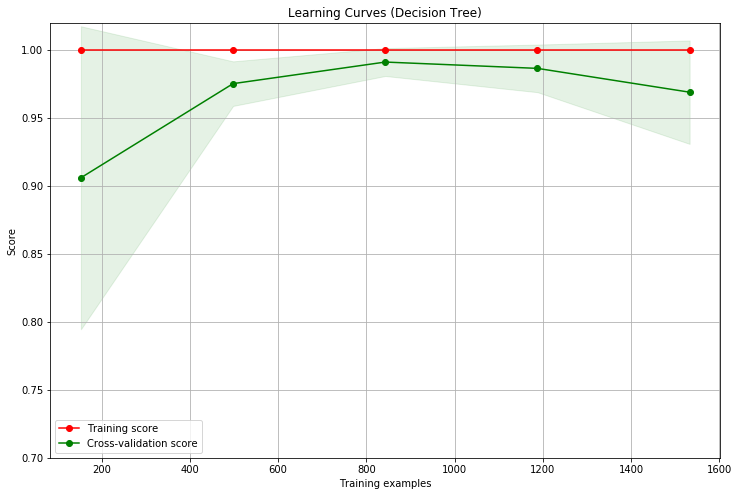

In [22]:
plt = plot_learning_curve(DecisionTreeClassifier(), "Learning Curves (Decision Tree)", X, y, ylim=(0.7, 1.02), cv=10)
plt.show()

## Ważność cech (ang. *feature importantes*)

Poniżej pojawi się trochę kodu, nie musisz go analizować, zwłaszcza jeśli masz z tym trudności. Celem tego kodu, jest wyciągnięcie informacji o cechach (ang. *features*) i oznaczenie które z nich są ważne (wg modelu, w tym przypadku drzewa decyzyjnego). 

In [23]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

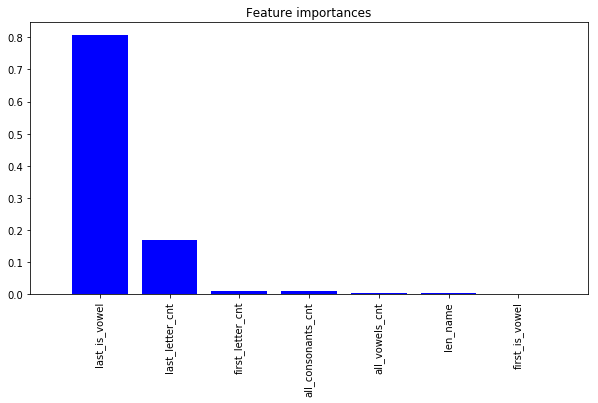

In [24]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

draw_feature_importances(model, features)

**Pamiętaj**, na wykresie widać, która cecha jest bardziej znacząca i nawet w tym przypadku to wygląda dość sensownie, jednak trzeba uważać i rozumieć jak to działa wewnątrz. Polecam obejrzeć wideo od [Amazona](https://www.youtube.com/watch?v=NLrhmn-EZ88). My także zgłębimy ten temat jak będziemy mówić o boosting.

*Swoją drogą*, jak myślisz co się stanie z ważnością cech, jeśli usuniemy pierwszą (czy druga będzie na pierwszym miejscu, trzecia na drugim itd czy nie) i dlaczego tak się dzieje?

## Przydatne linki
* [In machine learning, is more data always better than better algorithms?](https://www.quora.com/In-machine-learning-is-more-data-always-better-than-better-algorithms)
1. [Amazon Search: The Joy of Ranking Products - MLconf SF 2016 ](https://www.youtube.com/watch?v=NLrhmn-EZ88) Understand better what is the issue with standard feature importance by example.
* [sklearn: Decision Trees](http://scikit-learn.org/stable/modules/tree.html)